# Segmentação Semântica de Cenas Urbanas com Cityscapes: Uma Análise Comparativa de Modelos de Aprendizagem Profunda

##Importações e Downloads

In [ ]:
import os
import cv2
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2, ResNet50
from sklearn.model_selection import train_test_split, ShuffleSplit
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, UpSampling2D, BatchNormalization, Dropout, AveragePooling2D

##Análise de Dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Organização do Diretório

In [ ]:
pasta_cityscape = "/content/drive/MyDrive/Colab Notebooks/Introdução à Aprendizagem Profunda/cityscape"
print(sorted(os.listdir(pasta_cityscape)))

['gtFine_trainvaltest', 'leftImg8bit_trainvaltest']


In [ ]:
pasta_gtFine = pasta_cityscape + "/gtFine_trainvaltest/gtFine"
pasta_leftImg8bit = pasta_cityscape + "/leftImg8bit_trainvaltest/leftImg8bit"

print(sorted(os.listdir(pasta_leftImg8bit)))
print(sorted(os.listdir(pasta_gtFine)))

['test', 'train', 'val']
['test', 'train', 'val']


In [ ]:
pasta_gtFine_train = pasta_gtFine + "/train"
pasta_gtFine_val = pasta_gtFine + "/val"
pasta_gtFine_test = pasta_gtFine + "/test"

print(sorted(os.listdir(pasta_gtFine_train)))
print(sorted(os.listdir(pasta_gtFine_val)))
print(sorted(os.listdir(pasta_gtFine_test)))

['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']
['frankfurt', 'lindau', 'munster']
['berlin', 'bielefeld', 'bonn', 'leverkusen', 'mainz', 'munich']


In [ ]:
pasta_leftImg8bit_train = pasta_leftImg8bit + "/train"
pasta_leftImg8bit_val = pasta_leftImg8bit + "/val"
pasta_leftImg8bit_test = pasta_leftImg8bit + "/test"

print(sorted(os.listdir(pasta_leftImg8bit_train)))
print(sorted(os.listdir(pasta_leftImg8bit_val)))
print(sorted(os.listdir(pasta_leftImg8bit_test)))

['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']
['frankfurt', 'lindau', 'munster']
['berlin', 'bielefeld', 'bonn', 'leverkusen', 'mainz', 'munich']


In [ ]:
print(sorted(os.listdir(pasta_gtFine_train + "/aachen")))
print(sorted(os.listdir(pasta_gtFine_val + "/frankfurt")))
print(sorted(os.listdir(pasta_gtFine_test + "/berlin")))
print("\n")
print(sorted(os.listdir(pasta_leftImg8bit_train + "/aachen")))
print(sorted(os.listdir(pasta_leftImg8bit_val + "/frankfurt")))
print(sorted(os.listdir(pasta_leftImg8bit_test + "/berlin")))

As imagens do conjunto de dados Cityscapes são organizadas em dois principais diretórios: `gtFine` e `leftImg8bit`. Dentro desses diretórios, o conjunto de dados é subdividido em conjuntos de treinamento, validação e teste. Além disso, cada subconjunto é categorizado por cidade, refletindo diversas cidades urbanas, principalmente da Alemanha, nas quais as imagens foram coletadas.

Dentro da pasta `gtFine`, as imagens estão disponíveis em quatro formatos distintos, cada um com um propósito específico:

1. **gtFine_color**: Este formato representa as imagens coloridas originais, preservando informações de cor e textura. É útil para tarefas gerais de análise visual, como identificação de objetos, navegação de robôs autônomos ou qualquer aplicação em que a cor e os detalhes visuais sejam essenciais.

2. **gtFine_instanceIds**: Aqui, as imagens contêm informações de identificação de instância, permitindo a segmentação de objetos individuais dentro da cena. É ideal para tarefas de segmentação de instâncias, onde o objetivo é separar e identificar objetos individuais, como carros, pedestres ou bicicletas, em uma cena.

3. **gtFine_labelIds**: As imagens neste formato são usadas para a tarefa de segmentação semântica e atribuem um rótulo de classe a cada pixel, indicando a categoria semântica à qual o pixel pertence (por exemplo, carro, estrada, edifício). É apropriado para tarefas de segmentação semântica, onde o objetivo é rotular cada pixel em uma imagem com sua categoria semântica correspondente. Isso é útil em aplicações como mapeamento urbano, análise de tráfego, entre outras.

4. **gtFine_polygons (json)**: Este formato contém informações de segmentação poligonal em formato JSON, que descrevem os contornos das áreas de objetos na imagem. É adequado para tarefas de segmentação baseadas em contornos ou para análise mais detalhada da forma de objetos. Também pode ser útil para extrair informações geométricas precisas.

A divisão por cidade e a presença de quatro tipos de imagens (color, instanceIds, labelIds, polygons) permitem uma variedade de tarefas de visão computacional, como segmentação semântica, segmentação de instâncias e análise detalhada de objetos dentro da cena urbana.

###Análise das imagens

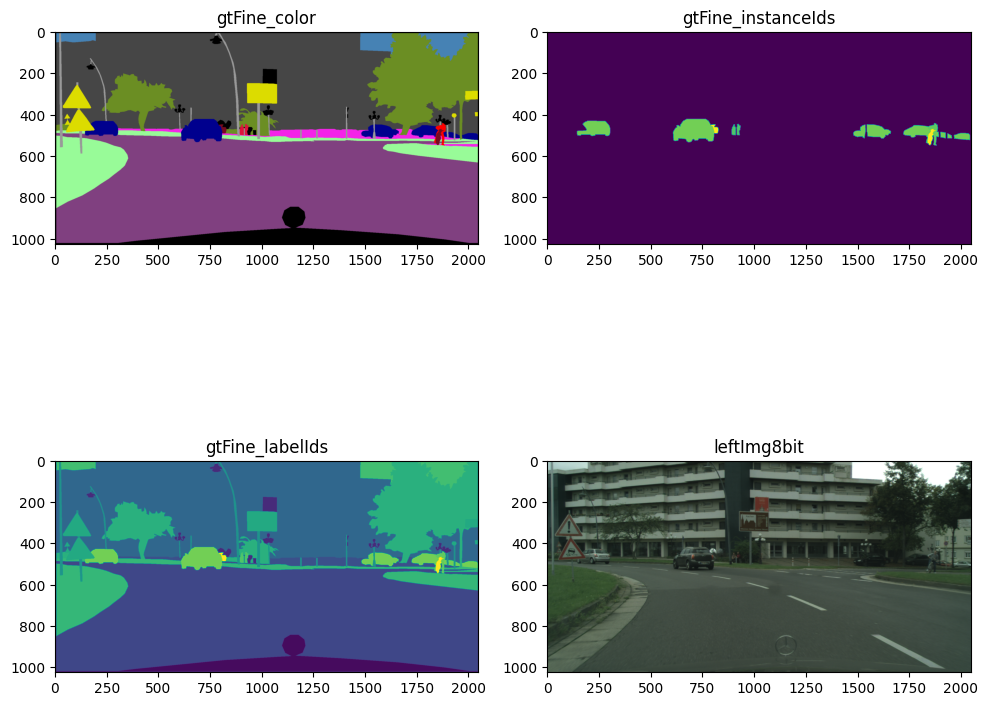

In [ ]:
img_gtFine_color = mpimg.imread(pasta_gtFine_train + "/aachen/aachen_000000_000019_gtFine_color.png")
img_gtFine_instanceIds = mpimg.imread(pasta_gtFine_train + "/aachen/aachen_000000_000019_gtFine_instanceIds.png")
img_gtFine_labelIds = mpimg.imread(pasta_gtFine_train + "/aachen/aachen_000000_000019_gtFine_labelIds.png")
json_gtFine_polygons = (pasta_gtFine_train + "/aachen/aachen_000000_000019_gtFine_polygons.json")
img_leftImg8bit = mpimg.imread(pasta_leftImg8bit_train + "/aachen/aachen_000000_000019_leftImg8bit.png")

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].set_title('gtFine_color')
axs[0, 1].set_title('gtFine_instanceIds')
axs[1, 0].set_title('gtFine_labelIds')
axs[1, 1].set_title('leftImg8bit')

axs[0, 0].imshow(img_gtFine_color)
axs[0, 1].imshow(img_gtFine_instanceIds)
axs[1, 0].imshow(img_gtFine_labelIds)
axs[1, 1].imshow(img_leftImg8bit)

plt.tight_layout()
plt.show()

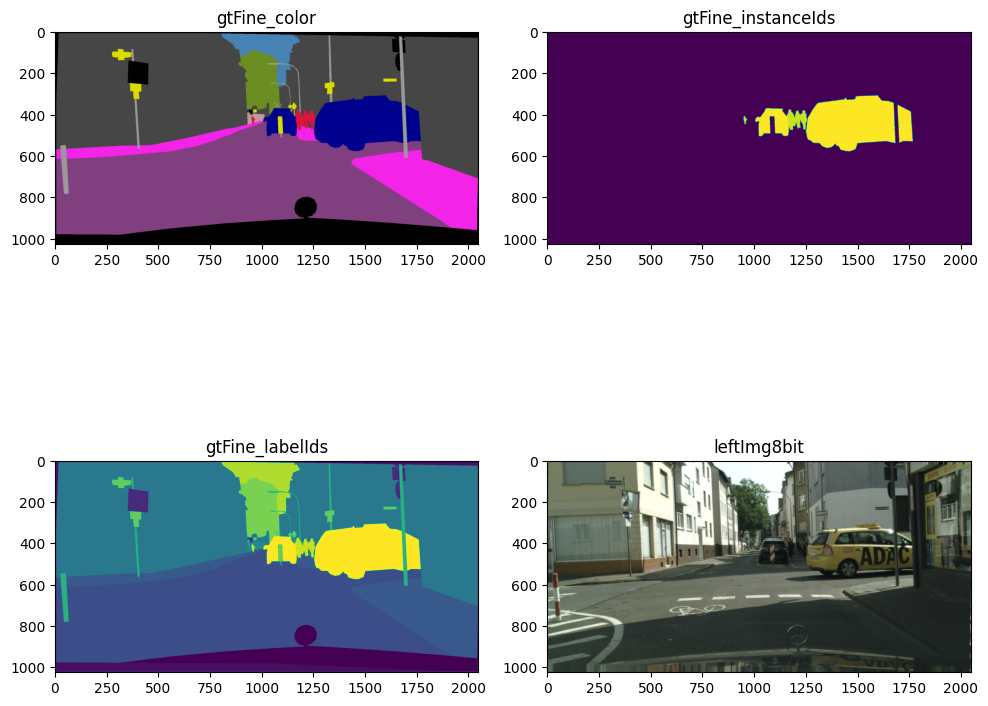

In [ ]:
img_gtFine_color = mpimg.imread(pasta_gtFine_val + "/frankfurt/frankfurt_000000_000294_gtFine_color.png")
img_gtFine_instanceIds = mpimg.imread(pasta_gtFine_val + "/frankfurt/frankfurt_000000_000294_gtFine_instanceIds.png")
img_gtFine_labelIds = mpimg.imread(pasta_gtFine_val + "/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png")
json_gtFine_polygons = (pasta_gtFine_val + "/frankfurt/frankfurt_000000_000294_gtFine_polygons.json")
img_leftImg8bit = mpimg.imread(pasta_leftImg8bit_val + "/frankfurt/frankfurt_000000_000294_leftImg8bit.png")

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].set_title('gtFine_color')
axs[0, 1].set_title('gtFine_instanceIds')
axs[1, 0].set_title('gtFine_labelIds')
axs[1, 1].set_title('leftImg8bit')

axs[0, 0].imshow(img_gtFine_color)
axs[0, 1].imshow(img_gtFine_instanceIds)
axs[1, 0].imshow(img_gtFine_labelIds)
axs[1, 1].imshow(img_leftImg8bit)

plt.tight_layout()
plt.show()

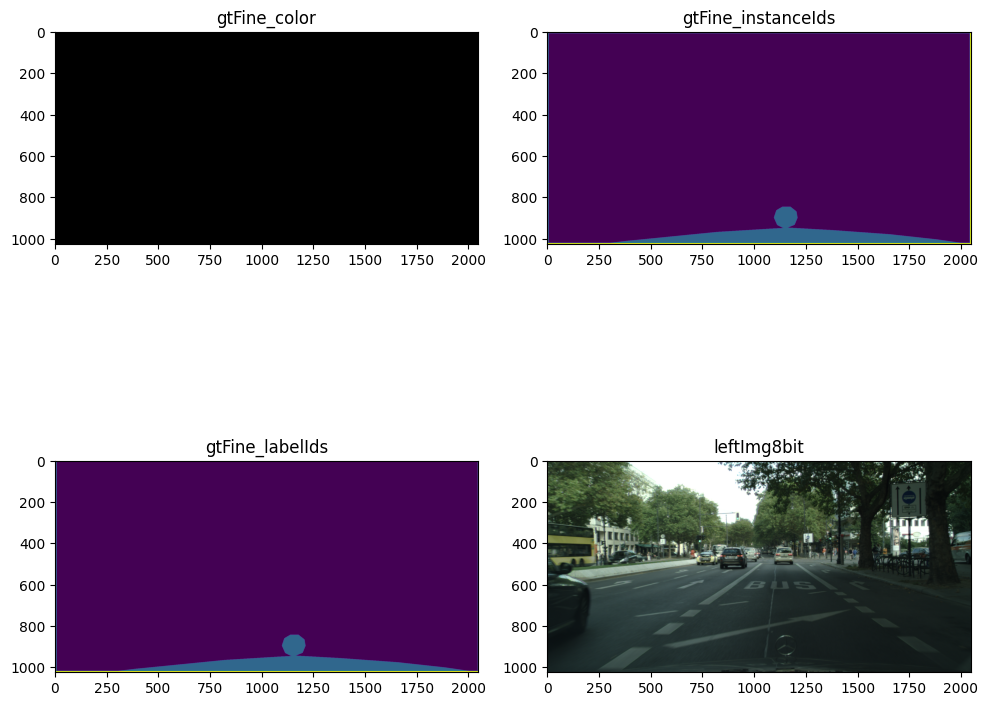

In [ ]:
img_gtFine_color = mpimg.imread(pasta_gtFine_test + "/berlin/berlin_000000_000019_gtFine_color.png")
img_gtFine_instanceIds = mpimg.imread(pasta_gtFine_test + "/berlin/berlin_000000_000019_gtFine_instanceIds.png")
img_gtFine_labelIds = mpimg.imread(pasta_gtFine_test + "/berlin/berlin_000000_000019_gtFine_labelIds.png")
json_gtFine_polygons = (pasta_gtFine_test + "/berlin/berlin_000000_000019_gtFine_polygons.json")
img_leftImg8bit = mpimg.imread(pasta_leftImg8bit_test + "/berlin/berlin_000000_000019_leftImg8bit.png")

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].set_title('gtFine_color')
axs[0, 1].set_title('gtFine_instanceIds')
axs[1, 0].set_title('gtFine_labelIds')
axs[1, 1].set_title('leftImg8bit')

axs[0, 0].imshow(img_gtFine_color)
axs[0, 1].imshow(img_gtFine_instanceIds)
axs[1, 0].imshow(img_gtFine_labelIds)
axs[1, 1].imshow(img_leftImg8bit)

plt.tight_layout()
plt.show()

As imagens no conjunto de teste não estão com a segmentação devida, como no de treino e validação.

###Caminho dos Dados

In [ ]:
def get_paths(gtFine, leftImg8bit, pasta):
  labels_path = os.path.join(gtFine, pasta)
  images_path = os.path.join(leftImg8bit, pasta)
  label_files = [os.path.join(labels_path,arq) for arq in os.listdir(labels_path) if 'gtFine_labelIds' in arq]
  img_files = [os.path.join(images_path,arq) for arq in os.listdir(images_path) if 'leftImg8bit' in arq]
  paths = list(zip(sorted(img_files), sorted(label_files)))
  return paths

In [ ]:
path_list = []

for pasta in tqdm(os.listdir(pasta_gtFine_train)):
  path_list += get_paths(pasta_gtFine_train, pasta_leftImg8bit_train, pasta)

for pasta in tqdm(os.listdir(pasta_gtFine_val)):
  path_list += get_paths(pasta_gtFine_val, pasta_leftImg8bit_val, pasta)

100%|██████████| 3/3 [00:00<00:00,  9.82it/s]


In [ ]:
len(path_list)

3475

In [ ]:
def print_img(path_list):
  fig, axs = plt.subplots(4, 2, figsize=(10, 10))

  for i in range(4):
    random_num = random.randint(0, len(path_list) - 1)
    axs[i, 0].imshow(mpimg.imread(path_list[random_num][0]))
    axs[i, 1].imshow(mpimg.imread(path_list[random_num][1]))

  plt.tight_layout()
  plt.show()

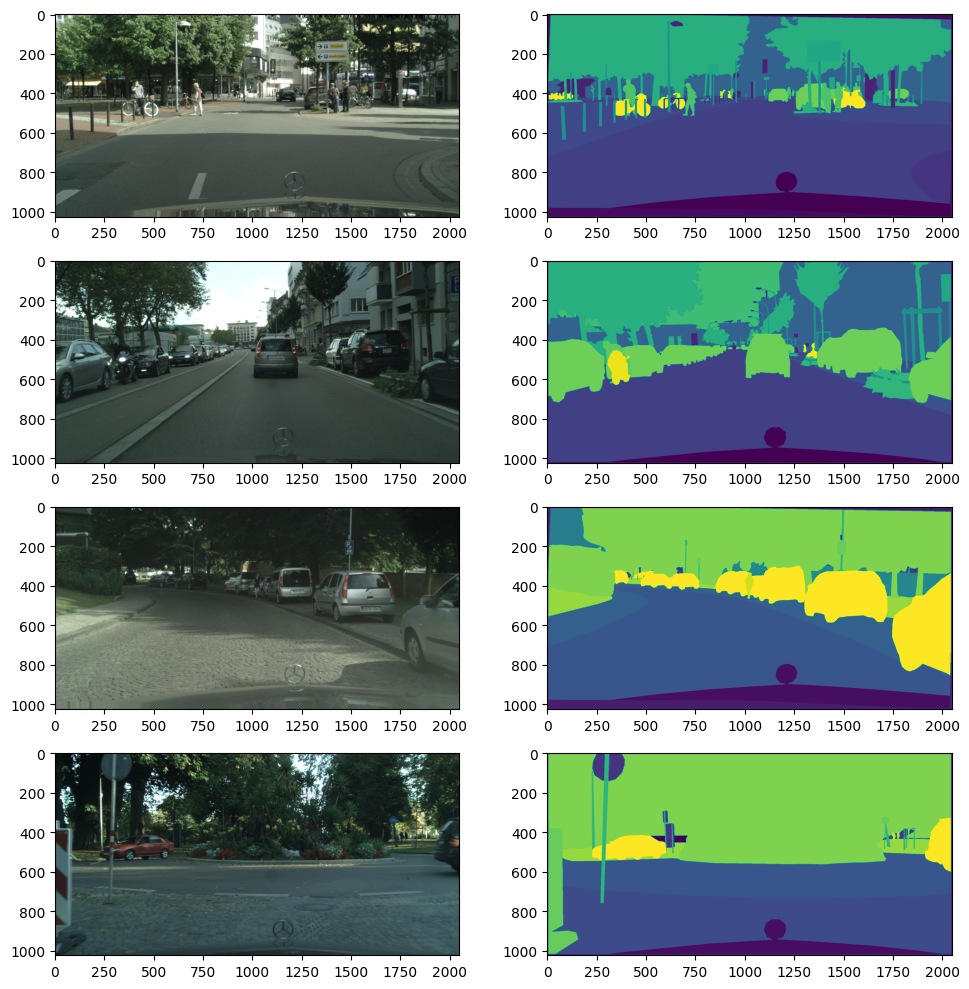

In [ ]:
print_img(path_list)

###Divisão dos dados

In [ ]:
images = []
labels = []

for image_path, label_path in tqdm(path_list[:500]):
  image = cv2.imread(image_path)
  image = cv2.resize(image, (256, 256))
  image = image / 255.0
  label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
  label = cv2.resize(label, (256, 256), interpolation=cv2.INTER_NEAREST)

  images.append(np.array(image))
  labels.append(np.array(label))

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

100%|██████████| 500/500 [01:09<00:00,  7.19it/s]


((350, 256, 256, 3),
 (75, 256, 256, 3),
 (75, 256, 256, 3),
 (350, 256, 256),
 (75, 256, 256),
 (75, 256, 256))

In [ ]:
from sklearn.preprocessing import normalize
x = np.expand_dims(X_train, axis=3)
train_x_norm = normalize(x.reshape(x.shape[0],-1), axis=1).reshape(x.shape)
train_y_norm = np.expand_dims(y_train, axis=3)

y = np.expand_dims(X_test, axis=3)
test_x_norm = normalize(y.reshape(y.shape[0],-1), axis=1).reshape(y.shape)
test_y_norm = np.expand_dims(y_test, axis=3)

z = np.expand_dims(X_val, axis=3)
val_x_norm = normalize(z.reshape(z.shape[0],-1), axis=1).reshape(z.shape)
val_y_norm = np.expand_dims(y_val, axis=3)

In [ ]:
n_classes = np.max(labels) + 1

train_y_cat = keras.utils.to_categorical(train_y_norm, num_classes=n_classes)
val_y_cat = keras.utils.to_categorical(val_y_norm, num_classes=n_classes)
test_y_cat = keras.utils.to_categorical(test_y_norm, num_classes=n_classes)

##Funções Comuns

In [ ]:
def fit_model(model):
  start_time = time.time()
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(X_train, train_y_cat, validation_data=(X_val, val_y_cat), batch_size=32, epochs=5)
  end_time = time.time()
  elapsed_time = end_time - start_time
  return elapsed_time

def eval_model(model):
  test_loss, test_accuracy = model.evaluate(X_test, test_y_cat)
  predictions = model.predict(X_test)

  true_positive = (predictions * test_y_cat).sum()
  false_positive = predictions.sum() - true_positive
  precision = true_positive / (true_positive + false_positive)

  correct_pixels = (predictions == test_y_cat).sum()
  total_pixels = predictions.size
  pixel_accuracy = correct_pixels / total_pixels

  intersection = (predictions * test_y_cat).sum(axis=(1, 2, 3))
  union = (predictions + test_y_cat - (predictions * test_y_cat)).sum(axis=(1, 2, 3))
  iou = (intersection / union).mean()

  class_iou = intersection / union
  mIoU = class_iou.mean()

  class_iou_dict = {}
  print("IoU por Classe:")
  for i in range(n_classes):
      class_iou_dict[f'Classe {i}'] = class_iou[:, i]
      print(f"Classe {i}: {class_iou[:, i]}")

  print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
  print(f'Precision: {precision}, Pixel Accuracy: {pixel_accuracy}')
  print(f'Intersection over Union (IoU): {iou}')
  print(f'Mean IoU (mIoU): {mIoU}')

  return class_iou_dict

def seg_sample(model):
  predictions = model.predict(X_test)
  fig, axs = plt.subplots(4, 3, figsize=(10, 10))

  predictions_resized = np.argmax(predictions, axis=-1)
  test_y_resized = np.argmax(test_y_cat, axis=-1)

  for i in range(4):
    random_num = random.randint(0, len(predictions) - 1)
    axs[i, 0].set_title('Original Image')
    axs[i, 1].set_title('True Mask')
    axs[i, 2].set_title('Predicted Mask')

    axs[i, 0].imshow(X_test[random_num])
    axs[i, 1].imshow(test_y_resized[random_num])
    axs[i, 2].imshow(predictions_resized[random_num])

  plt.tight_layout()
  plt.show()

##U-Net

A U-Net e um dos modelos mais populares para segmentação semântica devido à sua arquitetura encoder-decoder com conexões residuais. A estrutura em formato de U permite que informações de níveis de resolução mais altos sejam transmitidas para a fase de decodificação, o que facilita a recuperação de detalhes importantes na etapa de segmentação.

* Arquitetura em forma de U: A UNet tem uma arquitetura em forma de U, composta por uma metade descendente (encoder) e uma metade ascendente (decoder). Essa forma de U permite que a rede capture informações contextuais em diferentes escalas e, em seguida, as combine para produzir uma segmentação precisa.

* Camadas de convolução: A UNet usa camadas de convolução para extrair características das imagens de entrada. O encoder consiste em várias camadas de convolução para reduzir a resolução espacial e aumentar a representação semântica das características.

* Camadas de pooling: Entre as camadas de convolução do encoder, a UNet geralmente utiliza camadas de pooling (normalmente max-pooling) para reduzir ainda mais a resolução espacial e aumentar o campo receptivo das camadas convolucionais subsequentes.

* Conexões skip: Uma característica importante da UNet é a utilização de conexões skip entre as camadas do encoder e do decoder. Isso permite que as características de baixo nível do encoder sejam diretamente combinadas com as características de alto nível do decoder, o que ajuda a preservar informações detalhadas durante a fase de up-sampling.

* Função de ativação: A UNet frequentemente usa funções de ativação como ReLU (Rectified Linear Unit) para introduzir não-linearidade nas camadas convolucionais.

* Função de perda: A função de perda usada comumente na UNet depende da tarefa específica, mas em tarefas de segmentação, a perda Dice ou a perda de entropia cruzada são frequentemente usadas.

In [ ]:
def conv_block(x, filters, kernel_size=3):
    x = Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    x = Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    return x

def decoder_block(x, skip_connection, filters, kernel_size=3):
    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, skip_connection], axis=-1)
    x = conv_block(x, filters, kernel_size)
    return x

def unet(input_shape, n_classes):
    inputs = Input(input_shape)

    # Encoder
    encoder_blocks = []
    x = inputs
    for filters in [64, 128, 256, 512]:
        x = conv_block(x, filters)
        encoder_blocks.append(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # Bottleneck
    x = conv_block(x, 1024)

    # Decoder
    for filters, skip_connection in zip([512, 256, 128, 64], encoder_blocks[::-1]):
        x = decoder_block(x, skip_connection, filters)

    outputs = Conv2D(n_classes, 1, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = unet((256, 256, 3), n_classes)
model.summary()

# model.save('segmentation_model.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 256, 256, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 conv2d_12 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_11[0][0]']           
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_12[0][0]']           
 g2D)                                                                                         

In [ ]:
elapsed_time = fit_model(model)
unet_class_iou_dict = eval_model(model)
print(f'Time Elapsed: {elapsed_time}')
seg_sample(model)

##SegNet

O modelo SegNet também utiliza uma arquitetura encoder-decoder, mas com uma abordagem mais leve em relação a U-Net. Essa arquitetura foi projetada especificamente para a tarefa de segmentação semântica e busca um equilíbrio
entre desempenho e eficiência computacional.

* Encoder-Decoder Arquitetura: O SegNet adota uma arquitetura do tipo encoder-decoder, onde o encoder (codificador) é responsável por extrair características das imagens de entrada e o decoder (decodificador) reconstrói a segmentação a partir dessas características.

* Redução de Resolução Espacial: O encoder utiliza camadas de convolução para reduzir a resolução espacial das imagens de entrada. Isso é feito através de camadas de convolução e pooling, semelhante a muitas outras arquiteturas de segmentação.

* Uso de Max-Pooling com Pooling Indices: Uma característica distintiva do SegNet é que ele armazena os índices dos valores máximos durante as camadas de pooling. Isso permite que o decoder use esses índices para reconstruir a resolução espacial nas camadas de up-sampling (convolução transposta).

* Camadas de Up-Sampling: O decoder do SegNet utiliza camadas de up-sampling (convolução transposta) para aumentar a resolução espacial das características. Os índices de pooling armazenados são usados para realizar up-sampling reverso, o que ajuda a reconstruir a segmentação com detalhes espaciais precisos.

* Funções de Ativação: O SegNet normalmente usa funções de ativação, como ReLU, para introduzir não-linearidade nas camadas convolucionais.

* Função de Perda: A função de perda usada no SegNet depende da tarefa específica, mas, assim como na UNet, a perda de entropia cruzada é frequentemente usada para tarefas de segmentação.

In [ ]:
def create_segnet(input_shape, n_classes):
    inputs = Input(shape=input_shape)

    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    bn1 = BatchNormalization()(conv1)
    pool1, mask1 = MaxPoolingWithArgmax2D((2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool1)
    bn2 = BatchNormalization()(conv2)
    pool2, mask2 = MaxPoolingWithArgmax2D((2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same', activation='relu')(pool2)
    bn3 = BatchNormalization()(conv3)
    pool3, mask3 = MaxPoolingWithArgmax2D((2, 2))(bn3)

    up1 = UpSampling2D((2, 2))(pool3)
    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu')(up1)

    up2 = UpSampling2D((2, 2))(conv4)
    conv5 = Conv2D(128, (3, 3), padding='same', activation='relu')(up2)

    up3 = UpSampling2D((2, 2))(conv5)

    unpool1 = MaxUnpooling2D()([up3, mask3])
    unpool2 = MaxUnpooling2D()([unpool1, mask2])
    unpool3 = MaxUnpooling2D()([unpool2, mask1])

    outputs = Conv2D(n_classes, (3, 3), padding='same', activation='softmax')(unpool3)

    model = Model(inputs, outputs)
    return model

class MaxPoolingWithArgmax2D(Layer):
    def __init__(self, pool_size=(2, 2), **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs, **kwargs):
        pool_size = self.pool_size
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = 'VALID'
            strides = [1, pool_size[0], pool_size[1], 1]
            output, argmax = tf.nn.max_pool_with_argmax(inputs, ksize, strides, padding)
        else:
            errmsg = 'MaxPoolingWithArgmax2D supports only TensorFlow backend.'
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [dim // ratio[idx % 2] if dim is not None else None for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]

class MaxUnpooling2D(Layer):
    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with tf.variable_scope(self.name):
            mask = tf.cast(mask, 'int32')
            input_shape = tf.shape(updates, out_type='int32')
            output_shape = tf.cast(output_shape, 'int32')
            one_like_mask = tf.ones_like(mask, dtype='int32')
            batch_shape = tf.concat([[input_shape[0]], [1], [1], [1]], axis=0)
            batch_range = tf.reshape(tf.range(input_shape[0], dtype='int32'), shape=batch_shape)
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = tf.range(output_shape[3], dtype='int32')
            f = one_like_mask * feature_range
            updates_size = tf.size(updates)
            indices = tf.transpose(tf.reshape(tf.stack([b, y, x, f]), [4, updates_size]))
            values = tf.reshape(updates, [updates_size])
            ret = tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            (mask_shape[0], mask_shape[1], mask_shape[2], mask_shape[3]),
        )

model = create_segnet((256, 256, 3))
model.summary()

In [ ]:
def create_segnet(input_shape):
  inputs = Input(shape=input_shape)

  conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
  bn1 = BatchNormalization()(conv1)
  pool1 = MaxPooling2D((2, 2))(bn1)

  conv2 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool1)
  bn2 = BatchNormalization()(conv2)
  pool2 = MaxPooling2D((2, 2))(bn2)

  conv3 = Conv2D(256, (3, 3), padding='same', activation='relu')(pool2)
  bn3 = BatchNormalization()(conv3)
  pool3 = MaxPooling2D((2, 2))(bn3)

  up1 = UpSampling2D((2, 2))(pool3)
  conv4 = Conv2D(256, (3, 3), padding='same', activation='relu')(up1)

  up2 = UpSampling2D((2, 2))(conv4)
  conv5 = Conv2D(128, (3, 3), padding='same', activation='relu')(up2)

  up3 = UpSampling2D((2, 2))(conv5)

  outputs = Conv2D(n_classes, (3, 3), padding='same', activation='softmax')(up3)

  model = Model(inputs, outputs)
  return model

model = create_segnet((256, 256, 3))
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_62 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization_5 (Bat  (None, 256, 256, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 128, 128, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_63 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 batch_normalization_6 (Bat  (None, 128, 128, 128)     512 

In [ ]:
elapsed_time = fit_model(model)
segnet_class_iou_dict = eval_model(model)
print(f'Time Elapsed: {elapsed_time}')
seg_sample(model)

##FCN

O modelo FCN (Fully Convolutional Network) é uma arquitetura que transforma redes neurais convolucionais profundas em modelos para segmentação semântica. Ele permite a preservação da resolução espacial durante o processo de convolução, capturando informações contextuais em várias escalas.

* Camadas Convolucionais Completas: Ao contrário das arquiteturas tradicionais de CNN, as FCNs consistem principalmente em camadas convolucionais sem camadas densas (fully connected). Isso permite que a rede aceite imagens de qualquer tamanho de entrada e produza um mapa de segmentação do mesmo tamanho da entrada.

* Convoluções 1x1: As FCNs frequentemente utilizam convoluções 1x1 para reduzir a dimensionalidade das características e, ao mesmo tempo, aumentar o número de canais (ou classes de segmentação). Isso é útil para a fusão de informações de diferentes camadas e tamanhos de campo receptivo.

* Camadas de Up-Sampling: As FCNs incluem camadas de up-sampling (convolução transposta) para aumentar a resolução espacial do mapa de segmentação de saída para que ele corresponda ao tamanho da imagem de entrada.

* Fusão de Camadas de Diferentes Resoluções: Uma característica crítica das FCNs é a fusão de informações de diferentes camadas convolucionais para capturar detalhes de diferentes escalas. Isso geralmente é feito por meio de conexões skip, onde informações de camadas mais profundas são fundidas com informações de camadas menos profundas para obter uma segmentação precisa.

* Função de Ativação Softmax: A camada de saída das FCNs geralmente usa uma função de ativação softmax para atribuir probabilidades de pertencimento a cada classe de segmentação para cada pixel.

* Uso de Funções de Perda Específicas: Para tarefas de segmentação semântica, as FCNs frequentemente usam funções de perda, como a entropia cruzada, para comparar as previsões do modelo com as anotações da imagem de treinamento.

In [ ]:
def create_fcn(input_shape):
  inputs = Input(shape=input_shape)

  conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
  maxpool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv1)

  conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(maxpool1)
  conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
  maxpool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv2)

  conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(maxpool2)
  conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
  maxpool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv3)

  conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(maxpool3)
  conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

  up1 = UpSampling2D((2, 2))(conv4)
  concat1 = concatenate([conv3, up1], axis=-1)
  conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat1)

  up2 = UpSampling2D((2, 2))(conv5)
  concat2 = concatenate([conv2, up2], axis=-1)
  conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)

  up3 = UpSampling2D((2, 2))(conv6)
  concat3 = concatenate([conv1, up3], axis=-1)
  outputs = Conv2D(n_classes, (1, 1), activation='softmax', padding='same')(concat3)

  model = Model(inputs, outputs)
  return model

model = create_fcn((256, 256, 3))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_31 (Conv2D)          (None, 256, 256, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 conv2d_32 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_31[0][0]']           
                                                                                                  
 max_pooling2d_7 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_32[0][0]']           
 g2D)                                                                                       

In [ ]:
elapsed_time = fit_model(model)
fcn_class_iou_dict = eval_model(model)
print(f'Time Elapsed: {elapsed_time}')
seg_sample(model)

##DeepLab

O modelo DeepLab utiliza dilatações nas camadas convolucionais para aumentar o campo receptivo, melhorando a precisão da segmentação. Essa abordagem é particularmente eficaz para a captura de informações contextuais em uma área maior da imagem.

* Atrous (Dilated) Convolution: O DeepLab utiliza convoluções atrous (ou dilated convolutions) para aumentar o campo receptivo das camadas convolucionais sem reduzir a resolução espacial da entrada. Isso permite que a rede capture informações contextuais em várias escalas e resolva problemas de perda de detalhes que ocorrem com convoluções de tamanho fixo.

* ASPP (Atrous Spatial Pyramid Pooling): O ASPP é uma parte fundamental do DeepLab que ajuda a capturar informações contextuais em diferentes escalas. Ele utiliza múltiplas taxas de dilatação em paralelo para convoluções atrous e combina suas saídas. Isso permite que a rede capture informações contextuais em diferentes escalas espaciais.

* Backbone: O DeepLab pode ser construído com diferentes backbones, como ResNet, MobileNet, etc., para extrair características de nível mais alto. Esses backbones pré-treinados em grandes conjuntos de dados (como ImageNet) ajudam a melhorar o desempenho e a acelerar o treinamento.

* Pooling Espacial Através de Convoluções Atrous: O DeepLab também incorpora camadas de pooling espacial usando convoluções atrous. Isso ajuda a reduzir a resolução espacial da entrada para melhorar a eficiência computacional, enquanto mantém a capacidade de capturar informações contextuais em diferentes escalas.

* Camada de Saida de Convolução: A camada de saída do DeepLab geralmente consiste em uma convolução 1x1 para reduzir a dimensionalidade e produzir um mapa de segmentação com um número de canais igual ao número de classes de segmentação. A ativação Softmax é frequentemente usada para atribuir probabilidades de pertencimento a cada classe de segmentação para cada pixel.

* Uso de Funções de Perda Específicas: O DeepLab usa funções de perda apropriadas para tarefas de segmentação semântica, como a entropia cruzada.

In [ ]:
def atrous_spatial_pyramid_pooling(inputs):
  dilations = [1, 6, 12, 18]

  conv1x1_1 = Conv2D(256, (1, 1), padding='same', activation='relu')(inputs)
  conv1x1_2 = Conv2D(256, (1, 1), dilation_rate=(dilations[0], dilations[0]), padding='same', activation='relu')(inputs)
  conv1x1_3 = Conv2D(256, (1, 1), dilation_rate=(dilations[1], dilations[1]), padding='same', activation='relu')(inputs)
  conv1x1_4 = Conv2D(256, (1, 1), dilation_rate=(dilations[2], dilations[2]), padding='same', activation='relu')(inputs)
  conv1x1_5 = Conv2D(256, (1, 1), dilation_rate=(dilations[3], dilations[3]), padding='same', activation='relu')(inputs)

  concatenated = concatenate([conv1x1_1, conv1x1_2, conv1x1_3, conv1x1_4, conv1x1_5], axis=-1)
  return concatenated

def create_deeplab(input_shape):
  backbone = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

  aspp = atrous_spatial_pyramid_pooling(backbone.output)
  upsample = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(aspp)
  outputs = Conv2D(n_classes, (1, 1), padding='same', activation='softmax')(upsample)

  model = models.Model(backbone.input, outputs)
  return model

model = create_deeplab((256, 256, 3))
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_8[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 128, 128, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
elapsed_time = fit_model(model)
deeplab_class_iou_dict = eval_model(model)
print(f'Time Elapsed: {elapsed_time}')
seg_sample(model)

##PSPNet

A arquitetura PSPNet (Pyramid Scene Parsing Network) utiliza pirâmides de pooling para capturar informações contextuais em diferentes escalas, possibilitando uma compreensão mais abrangente da cena.

* Camada PSP (Pyramid Pooling Module): A característica central do PSPNet é a camada PSP, que captura informações contextuais em várias escalas espaciais. Ela divide a representação intermediária da imagem em várias regiões, calcula a média global ou a max-pooling em cada região e concatena essas informações para criar um vetor de contexto. Isso ajuda a rede a capturar informações de contexto em várias escalas, permitindo a segmentação precisa de objetos em diferentes tamanhos.

* Backbone: O PSPNet geralmente usa uma rede neural profunda pré-treinada, como ResNet ou VGG, como seu backbone para extrair características de nível mais alto. Esses backbones pré-treinados em grandes conjuntos de dados, como ImageNet, ajudam a melhorar o desempenho e a acelerar o treinamento.

* Camadas Convolutivas: Após a camada PSP, o PSPNet utiliza camadas convolutivas para refinar ainda mais a representação e produzir a saída de segmentação.

* Uso de Funções de Perda Específicas: O PSPNet usa funções de perda apropriadas para tarefas de segmentação semântica, como a entropia cruzada.

In [ ]:
def pyramid_pooling_module(input_tensor, pool_sizes=[1, 2, 3, 6]):
  concat_layers = [input_tensor]

  for size in pool_sizes:
    pooled = AveragePooling2D(pool_size=(input_tensor.shape[1] // size, input_tensor.shape[2] // size))(input_tensor)
    conv = Conv2D(256, (1, 1), padding='same')(pooled)
    upsampled = UpSampling2D(size=(input_tensor.shape[1] // size, input_tensor.shape[2] // size))(conv)
    concat_layers.append(upsampled)

  return concatenate(concat_layers, axis=-1)

def create_pspnet(input_shape):
  inputs = Input(shape=input_shape)

  backbone = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)

  encoder_output = backbone.get_layer('conv4_block6_out').output

  psp = pyramid_pooling_module(backbone.output)

  x = Conv2D(512, (3, 3), padding='same', activation='relu')(psp)
  x = BatchNormalization()(x)
  x = Conv2D(256, (1, 1), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  outputs = Conv2D(n_classes, (1, 1), activation='softmax', padding='same')(x)

  model = Model(inputs=backbone.input, outputs=outputs)
  return model

model = create_pspnet((256, 256, 3))
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_10[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                       

In [ ]:
elapsed_time = fit_model(model)
pspnet_class_iou_dict = eval_model(model)
print(f'Time Elapsed: {elapsed_time}')
seg_sample(model)

##Salvar como PDF

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
pandoc set to manually installed.
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1
  libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:


In [ ]:
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Colab Notebooks/Introdução à Aprendizagem Profunda/Cityscape.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Introdução à Aprendizagem Profunda/Cityscape.ipynb to PDF
[NbConvertApp] Support files will be in Cityscape_files/
[NbConvertApp] Making directory ./Cityscape_files
[NbConvertApp] Making directory ./Cityscape_files
[NbConvertApp] Making directory ./Cityscape_files
[NbConvertApp] Making directory ./Cityscape_files
[NbConvertApp] Writing 173226 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1329354 bytes to /content/drive/MyDrive/Colab Notebooks/Introdução à Aprendizagem Profunda/Cityscape.pdf
